In [1]:
using GuSTO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/37963de6d08bd2e6fe9e206e2e9943687644a3d1-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/37963de6d08bd2e6fe9e206e2e9943687644a3d1-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
robot = Car()
model = DubinsCar()
env = BlankEnv()

N = 41
x_init = 2*ones(3)
x_goal = zeros(3)
tf_guess = 5.

PD = ProblemDefinition(robot, model, env, x_init, x_goal)

TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)

TrajectoryOptimizationProblem{Car,DubinsCar,BlankEnv}(ProblemDefinition{Car,DubinsCar,BlankEnv}(Car((class btCollisionObject *) @0x0000000005a6f9e0
), DubinsCar(3, 1, 2.0, 1.0, [-100.0, -100.0, -6.28319], [100.0, 100.0, 6.28319], -10.0, 10.0, 0.01, Any[], Any[], Any[]), BlankEnv([-1000.0, -1000.0, -1000.0], [1000.0, 1000.0, 1000.0], GeometryTypes.GeometryPrimitive[], GeometryTypes.GeometryPrimitive[], GeometryTypes.GeometryPrimitive[]), [2.0, 2.0, 2.0], [0.0, 0.0, 0.0]), Workspace(BulletCollision.BulletStaticEnvironment((class btCollisionObject *) @0x0000000005a6f9e0
, Cxx.CppPtr{Cxx.CxxQualType{Cxx.CppBaseType{:btCollisionObject},(false, false, false)},(false, false, false)}[(class btCollisionObject *) @0x000000000897aea0
], (class btCollisionWorld *) @0x0000000009322d10
, Cxx.CppPtr{Cxx.CxxQualType{Cxx.CppBaseType{:btCollisionObject},(false, false, false)},(false, false, false)}[], 0), BulletCollision.BulletStaticEnvironment((class btCollisionObject *) @0x0000000005a6f9e0
, Cxx.CppPt

In [22]:
# SCP Only
TOS_SCP = TrajectoryOptimizationSolution(TOP)
solve_SCP!(TOS_SCP, TOP, solve_gusto_cvx!, init_traj_straightline, "Gurobi", OutputFlag=0)
# solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "IPOPT", print_level=0)

@show TOS_SCP.SCPS.converged
@show TOS_SCP.SCPS.iterations
@show TOS_SCP.SCPS.total_time
@show TOS_SCP.SCPS.J_true[end]

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Tuple{Int64,Int64}) at ./deprecated.jl:57
 [3] fix! at /home/thomas/.julia/v0.6/Convex/src/variable.jl:127 [inlined]
 [4] SCPVariables{Convex.Variable,Convex.Variable}(::SCPProblem{Car,DubinsCar,BlankEnv}) at /home/thomas/.julia/v0.6/GuSTO/src/types.jl:97
 [5] #solve_gusto_cvx!#6(::Array{Any,1}, ::Function, ::SCPSolution, ::SCPProblem{Car,DubinsCar,BlankEnv}, ::String, ::Int64, ::Bool) at /home/thomas/.julia/v0.6/GuSTO/src/scp/scp_gusto.jl:59
 [6] (::#kw##solve_gusto_cvx!)(::Array{Any,1}, ::#solve_gusto_cvx!, ::SCPSolution, ::SCPProblem{Car,DubinsCar,BlankEnv}, ::String, ::Int64, ::Bool) at ./<missing>:0
 [7] #solve_SCP!#5(::Array{Any,1}, ::Function, ::TrajectoryOptimizationSolution, ::TrajectoryOptimizationProblem{Car,DubinsCar,BlankEnv}, ::#solve_gusto_cvx!, ::#init_traj_straightline, ::String) at /home/thomas/.julia/v0.6/GuSTO/src/traj_opt.jl:49
 [8] (::#kw##solve_SCP!)(::Array{Any,1}, :

Academic license - for non-commercial use only
TOS_SCP.SCPS.converged = true
TOS_SCP.SCPS.iterations = 6
TOS_SCP.SCPS.total_time = 1.506673614
TOS_SCP.SCPS.J_true[end] = 18.90326415068619


18.90326415068619

In [8]:
@show TOS_SCP.SCPS.converged
@show TOS_SCP.SCPS.iterations
@show TOS_SCP.SCPS.iter_elapsed_times
@show TOS_SCP.SCPS.total_time
@show TOS_SCP.SCPS.accept_solution
@show TOS_SCP.SCPS.prob_status
@show TOS_SCP.SCPS.convergence_measure
@show TOS_SCP.SCPS.param.alg.omega_vec
@show TOS_SCP.SCPS.param.alg.Delta_vec

TOS_SCP.SCPS.converged = true
TOS_SCP.SCPS.iterations = 6
TOS_SCP.SCPS.iter_elapsed_times = Any[0.0107618, 0.0105551, 0.0103189, 0.00936085, 0.00904786, 0.0081317]
TOS_SCP.SCPS.total_time = 0.058176268999999996
TOS_SCP.SCPS.accept_solution = Bool[true]
TOS_SCP.SCPS.prob_status = Symbol[:NA]
TOS_SCP.SCPS.convergence_measure = [0.0, 1.0158, 1.7599, 0.432085, 0.33266, 0.126617, 0.0390432]
TOS_SCP.SCPS.param.alg.omega_vec = [1.0]
TOS_SCP.SCPS.param.alg.Delta_vec = [10000.0]


1-element Array{Float64,1}:
 10000.0

In [9]:
TOS_SCPS  = TrajectoryOptimizationSolution(TOP)
solve_SCPshooting!(TOS_SCPS, TOP, solve_gusto_jump!, init_traj_straightline, "IPOPT", print_level=0)

@show TOS_SCPS.SS.converged
@show TOS_SCPS.SCPS.total_time

TOS_SCPS.SS.converged = false
TOS_SCPS.SCPS.total_time = 0.102923572


0.102923572

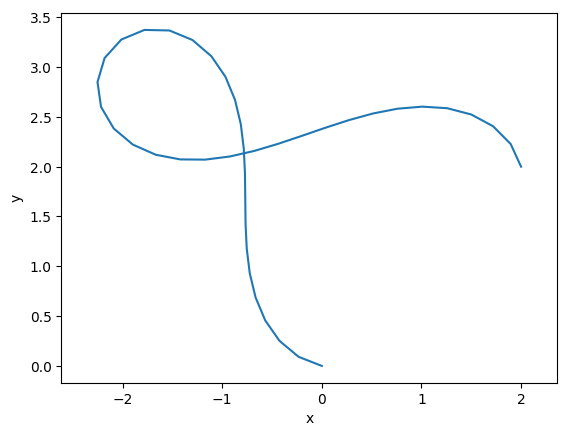

(-2.4641977885826214, 2.2125808470753627, -0.16863271570313243, 3.541287029765781)

In [10]:
using PyPlot
plot(TOS_SCP.SCPS.traj.X[1,:], TOS_SCP.SCPS.traj.X[2,:])
xlabel("x")
ylabel("y")
axis("equal")